# RF & XGBoost Modelling


In [1]:
from pathlib import Path
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    root_mean_squared_error,
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
train_data = Path("__file__").parent / "data" / "train_full.csv"
train_data = Path("__file__").parent / "data" / "test_full.csv"
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

original_df = pd.concat([train_df, test_df], axis=0)
df = original_df.copy()

In [3]:
df.head()

,year_month,year,month,precipitation_mean,precipitation_sum,max_temp_mean,max_temp_max,min_temp_mean,min_temp_min,avg_temp_mean,avg_temp_std,precipitation_count,price_usd_per_tonne_mean,price_usd_per_tonne_std,Mid Rate_mean,Mid Rate_std
0,1996-01-01,1996,1,-0.861464,-1.011531,0.462460,-0.238712,0.947776,1.934933,0.438983,0.376641,0,1349.541364,10.184784,1469.078409,14.536908
1,1996-02-01,1996,2,-0.861464,-1.011531,0.462460,-0.238712,0.838467,1.934933,1.344259,-0.256773,0,1369.839524,17.896659,1518.639000,13.286225
2,1996-03-01,1996,3,-0.861464,-1.011531,0.462460,-0.238712,0.729157,1.934933,1.222199,0.619708,0,1338.600952,26.267301,1561.531500,11.793660
3,1996-04-01,1996,4,-0.861464,-1.011531,0.016635,-0.155776,0.619848,1.934933,1.079796,3.327665,0,1456.279524,31.037661,1595.029250,8.399923
4,1996-05-01,1996,5,0.786976,0.665290,-0.429190,-0.072839,0.491019,0.027792,-0.191387,1.888106,14,1524.020455,17.324733,1618.618636,7.556588


## Process Data


In [4]:
df.drop(columns=["year_month"], inplace=True)

### Lags


In [5]:
num_lags = 3

features_to_lag = list(df.columns)
features_to_lag.remove("year")
features_to_lag.remove("month")

for lag in range(1, num_lags + 1):
    for feature in features_to_lag:
        df[f"lag {lag} expected {feature}"] = df[feature].shift(lag)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df.head()

,year,month,precipitation_mean,precipitation_sum,max_temp_mean,max_temp_max,min_temp_mean,min_temp_min,avg_temp_mean,avg_temp_std,...,lag 3 expected max_temp_max,lag 3 expected min_temp_mean,lag 3 expected min_temp_min,lag 3 expected avg_temp_mean,lag 3 expected avg_temp_std,lag 3 expected precipitation_count,lag 3 expected price_usd_per_tonne_mean,lag 3 expected price_usd_per_tonne_std,lag 3 expected Mid Rate_mean,lag 3 expected Mid Rate_std
0,1996,4,-0.861464,-1.011531,0.016635,-0.155776,0.619848,1.934933,1.079796,3.327665,...,-0.238712,0.947776,1.934933,0.438983,0.376641,0.0,1349.541364,10.184784,1469.078409,14.536908
1,1996,5,0.786976,0.665290,-0.429190,-0.072839,0.491019,0.027792,-0.191387,1.888106,...,-0.238712,0.838467,1.934933,1.344259,-0.256773,0.0,1369.839524,17.896659,1518.639000,13.286225
2,1996,6,-0.319452,-0.657095,-0.694143,-1.137191,-0.760184,-0.265617,-0.875702,0.064939,...,-0.238712,0.729157,1.934933,1.222199,0.619708,0.0,1338.600952,26.267301,1561.531500,11.793660
3,1996,7,-0.032956,0.553617,-1.520652,-1.068077,-1.056734,-0.705726,-1.763279,-1.134600,...,-0.155776,0.619848,1.934933,1.079796,3.327665,0.0,1456.279524,31.037661,1595.029250,8.399923
4,1996,8,-0.340090,-0.064477,-1.699671,2.525838,-1.079308,0.086471,-1.960771,-1.146772,...,-0.072839,0.491019,0.027792,-0.191387,1.888106,14.0,1524.020455,17.324733,1618.618636,7.556588


# Model Training & Prediction


## Random Forest


In [7]:
metrics = {}

In [8]:
X = df.drop(columns=features_to_lag)
y = df[features_to_lag]

In [9]:
train_window_size = 24
test_window_size = 4

label_index = y.columns.get_loc("price_usd_per_tonne_mean")

In [10]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=100,
    n_jobs=-1,
)
model = MultiOutputRegressor(model)

In [ ]:
def train(model, X, y, train_window_size, test_window_size):
    train_predictions = []
    train_ground_truth = []
    test_predictions = []
    test_ground_truth = []
    feature_importances = []

    for i in tqdm(range(0, (len(X) - train_window_size) // test_window_size)):
        start_train = i * test_window_size
        end_train = start_train + train_window_size
        start_test = end_train
        end_test = start_test + test_window_size
        X_train = X.iloc[start_train:end_train]
        y_train = y.iloc[start_train:end_train]
        X_test = X.iloc[start_test:end_test]
        y_test = y.iloc[start_test:end_test]

        model.fit(X_train, y_train)
        feature_importances.append(model.estimators_[label_index].feature_importances_)

        if i == 0:
            train_predictions.extend(model.predict(X_train)[:, label_index])
            train_ground_truth.extend(y_train.iloc[:, label_index])
        else:
            train_predictions.extend(
                model.predict(X_train.iloc[-test_window_size:, :])[:, label_index]
            )
            train_ground_truth.extend(y_train.iloc[-test_window_size:, label_index])

        for test_month in range(test_window_size):
            X_test_month = X_test.iloc[test_month].copy()
            expected_values = model.predict(X_test_month.to_frame().T)[0]

            for lag in range(num_lags, 1, -1):
                for feature in features_to_lag:
                    X_test_month.loc["lag " + str(lag) + " expected " + feature] = (
                        X_test_month.loc["lag " + str(lag) + " expected " + feature]
                    )

            for feature, expected_value in zip(features_to_lag, expected_values):
                X_test_month.loc["lag 1 expected " + feature] = expected_value

            test_predictions.append(expected_values[label_index])
            test_ground_truth.append(y_test.iloc[test_month, label_index])

    feature_importances = np.mean(feature_importances, axis=0)

    return (
        train_predictions,
        train_ground_truth,
        test_predictions,
        test_ground_truth,
        feature_importances,
    )

In [12]:
(
    rf_train_predictions,
    rf_train_ground_truth,
    rf_test_predictions,
    rf_test_ground_truth,
    rf_feature_importances,
) = train(
    model,
    X,
    y,
    train_window_size,
    test_window_size,
)

100%|██████████| 80/80 [04:44<00:00,  3.56s/it]


In [13]:
metrics["Random Forest"] = {
    "Train": {
        "MAE": mean_absolute_error(rf_train_predictions, rf_train_ground_truth),
        "MSE": mean_squared_error(rf_train_predictions, rf_train_ground_truth),
        "RMSE": root_mean_squared_error(rf_train_predictions, rf_train_ground_truth),
    },
    "Test": {
        "MAE": mean_absolute_error(rf_test_predictions, rf_test_ground_truth),
        "MSE": mean_squared_error(rf_test_predictions, rf_test_ground_truth),
        "RMSE": root_mean_squared_error(rf_test_predictions, rf_test_ground_truth),
    },
}

In [14]:
date_spacing = 15
dates = original_df.loc[:, "year_month"][3:]
dates = [dates.split("-")[0] + "-" + dates.split("-")[1] for dates in dates]

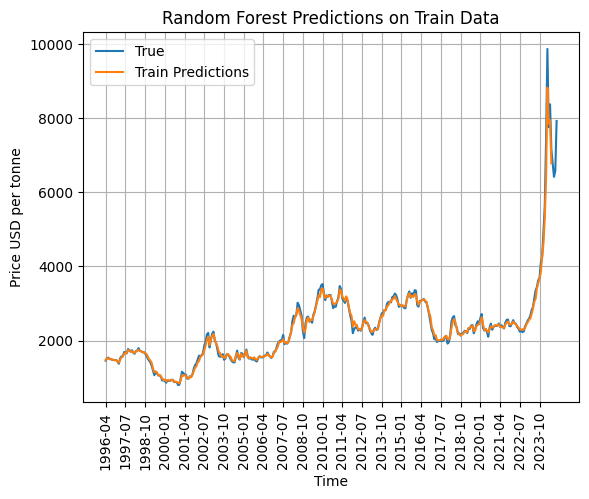

In [ ]:
plt.plot(y.iloc[:, label_index], label="True")
plt.plot(
    range(len(rf_train_predictions)), rf_train_predictions, label="Train Predictions"
)
plt.xticks(
    ticks=range(0, len(dates), date_spacing), labels=dates[::date_spacing], rotation=90
)
plt.grid()

plt.title("Random Forest Predictions on Train Data")
plt.xlabel("Time")
plt.ylabel("Price USD per tonne")
plt.legend()

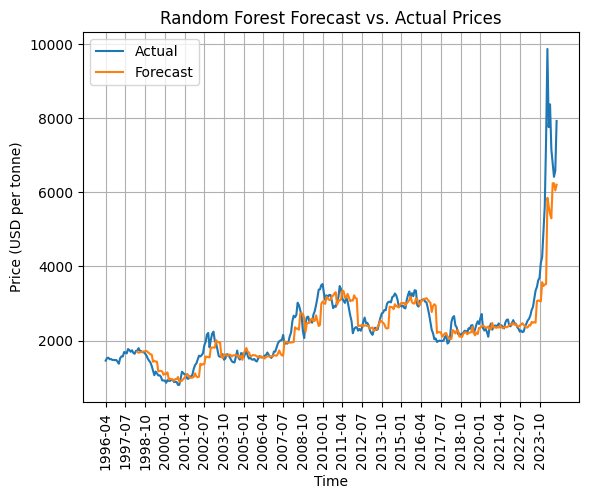

In [80]:
# overlay predictions
plt.plot(y.iloc[:, label_index], label="Actual")
plt.plot(
    range(train_window_size, train_window_size + len(rf_test_predictions)),
    rf_test_predictions,
    label="Forecast",
)
plt.xticks(
    ticks=range(0, len(dates), date_spacing), labels=dates[::date_spacing], rotation=90
)
plt.grid()

plt.title("Random Forest Forecast vs. Actual Prices")
plt.xlabel("Time")
plt.ylabel("Price (USD per tonne)")
plt.legend()

## XGBoost


In [69]:
xg_model = GradientBoostingRegressor(
    n_estimators=20,
    random_state=42,
    max_depth=3,
)
xg_model = MultiOutputRegressor(xg_model)

In [70]:
(
    xgboost_train_predictions,
    xgboost_train_ground_truth,
    xgboost_test_predictions,
    xgboost_test_ground_truth,
    xgboost_feature_importances,
) = train(
    xg_model,
    X,
    y,
    train_window_size,
    test_window_size,
)

100%|██████████| 80/80 [00:23<00:00,  3.48it/s]


In [71]:
metrics["XGBoost"] = {
    "Train": {
        "MAE": mean_absolute_error(
            xgboost_train_predictions, xgboost_train_ground_truth
        ),
        "MSE": mean_squared_error(
            xgboost_train_predictions, xgboost_train_ground_truth
        ),
        "RMSE": root_mean_squared_error(
            xgboost_train_predictions, xgboost_train_ground_truth
        ),
        
    },
    "Test": {
        "MAE": mean_absolute_error(xgboost_test_predictions, xgboost_test_ground_truth),
        "MSE": mean_squared_error(xgboost_test_predictions, xgboost_test_ground_truth),
        "RMSE": root_mean_squared_error(
            xgboost_test_predictions, xgboost_test_ground_truth
        ),
    },
}

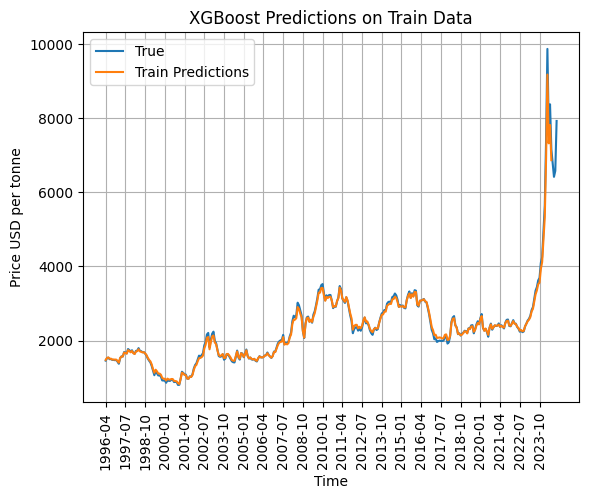

In [72]:
plt.plot(y.iloc[:, label_index], label="True")
plt.plot(
    range(len(xgboost_train_predictions)),
    xgboost_train_predictions,
    label="Train Predictions",
)
plt.xticks(
    ticks=range(0, len(dates), date_spacing), labels=dates[::date_spacing], rotation=90
)
plt.grid()

plt.title("XGBoost Predictions on Train Data")
plt.xlabel("Time")
plt.ylabel("Price USD per tonne")
plt.legend()

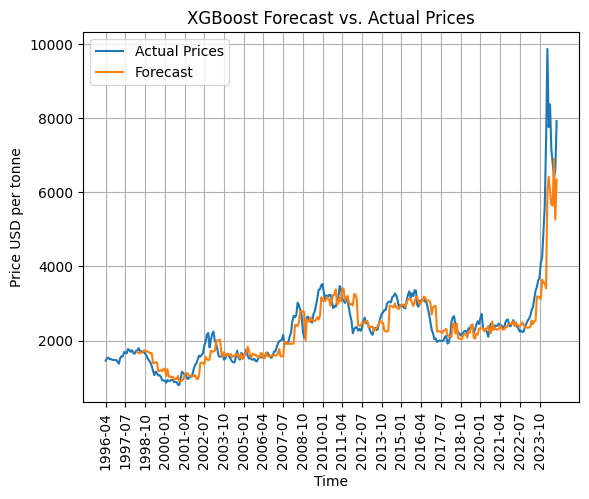

In [ ]:
plt.plot(y.iloc[:, label_index], label="Actual Prices")
plt.plot(
    range(train_window_size, train_window_size + len(xgboost_test_predictions)),
    xgboost_test_predictions,
    label="Forecast",
)
plt.xticks(
    ticks=range(0, len(dates), date_spacing), labels=dates[::date_spacing], rotation=90
)
plt.grid()

plt.title("XGBoost Forecast vs. Actual Prices")
plt.xlabel("Time")
plt.ylabel("Price (USD per tonne)")
plt.legend()

## Analysis


### Metrics

In [74]:
print(pd.DataFrame(metrics['Random Forest']).T)
print(pd.DataFrame(metrics['XGBoost']).T)

              MAE            MSE        RMSE
Train   54.023528   11663.426895  107.997347
Test   267.351775  265683.818654  515.445263
              MAE            MSE        RMSE
Train   41.587392    6213.552939   78.826093
Test   270.514324  247022.014683  497.013093


### Feature Importance

(-1.0, 10.0)

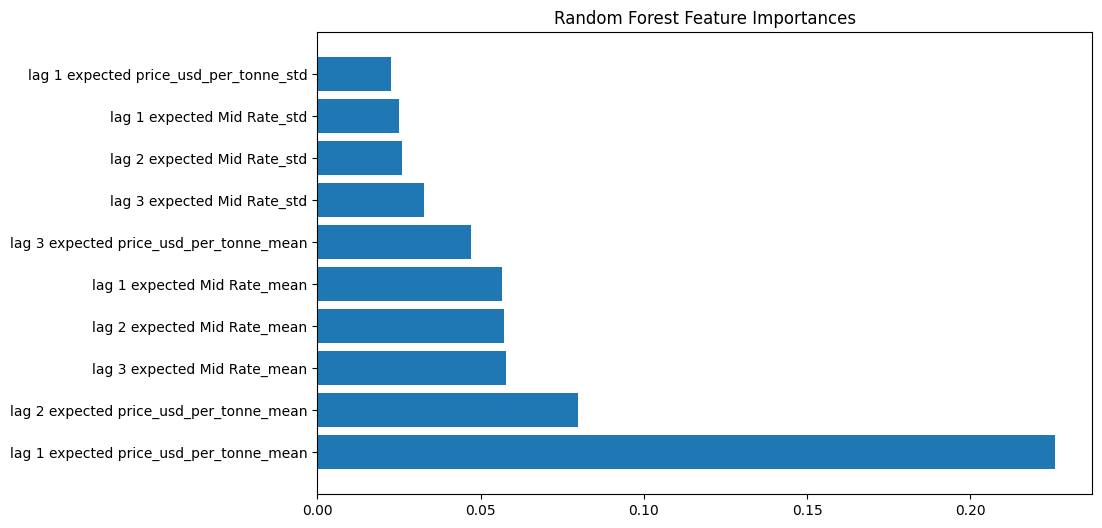

In [75]:
feature_names = X.columns
indices = np.argsort(rf_feature_importances)[::-1]

indices = indices[:10]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.barh(range(len(indices)), rf_feature_importances[indices], align="center")
plt.yticks(range(len(indices)), feature_names[indices])
plt.ylim([-1, len(indices)])

(-1.0, 10.0)

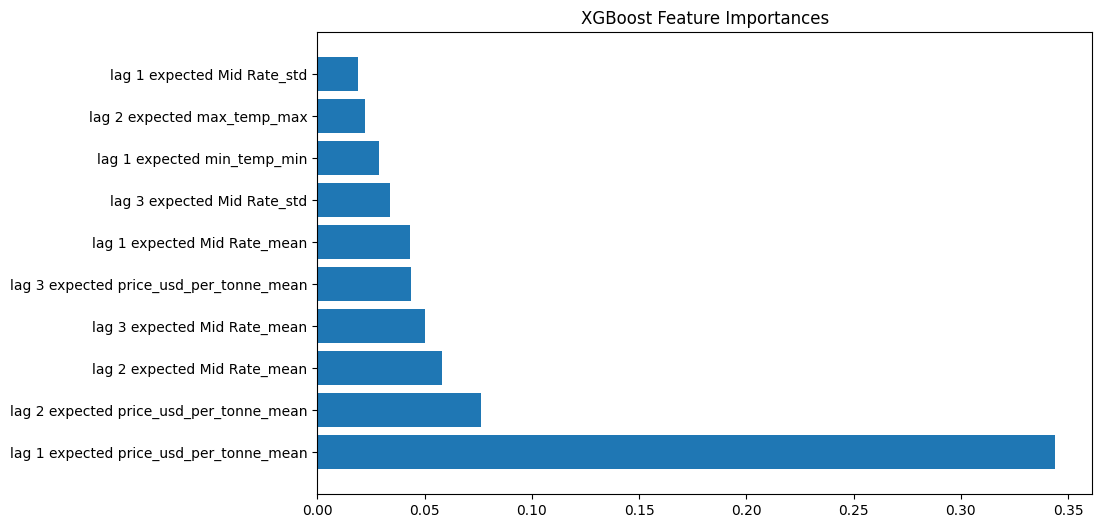

In [76]:
feature_names = X.columns
indices = np.argsort(xgboost_feature_importances)[::-1]
indices = indices[:10]
plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importances")
plt.barh(range(len(indices)), xgboost_feature_importances[indices], align="center")
plt.yticks(range(len(indices)), feature_names[indices])
plt.ylim([-1, len(indices)])

### Residual Analysis

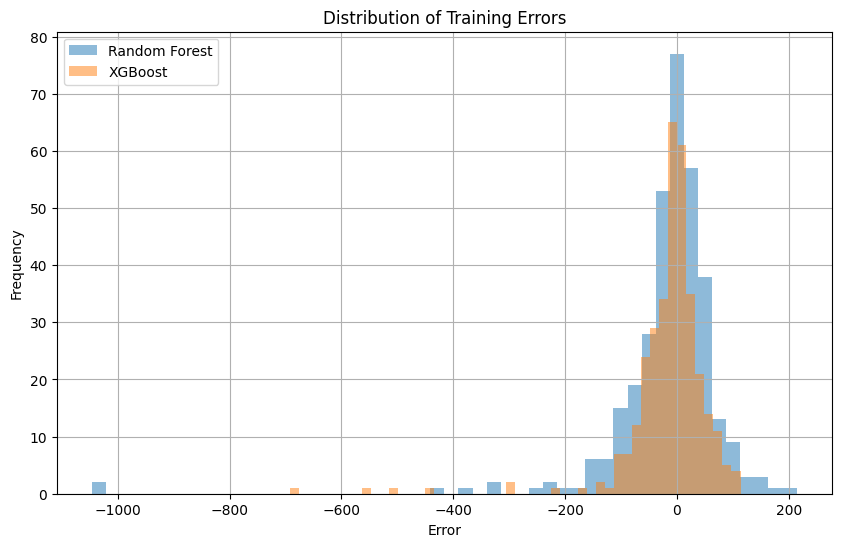

In [77]:
plt.figure(figsize=(10, 6))
plt.hist(
    np.array(rf_train_predictions) - np.array(rf_train_ground_truth),
    bins=50,
    alpha=0.5,
    label="Random Forest",
)
plt.hist(
    np.array(xgboost_train_predictions) - np.array(xgboost_train_ground_truth),
    bins=50,
    alpha=0.5,
    label="XGBoost",
)

plt.title("Distribution of Training Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

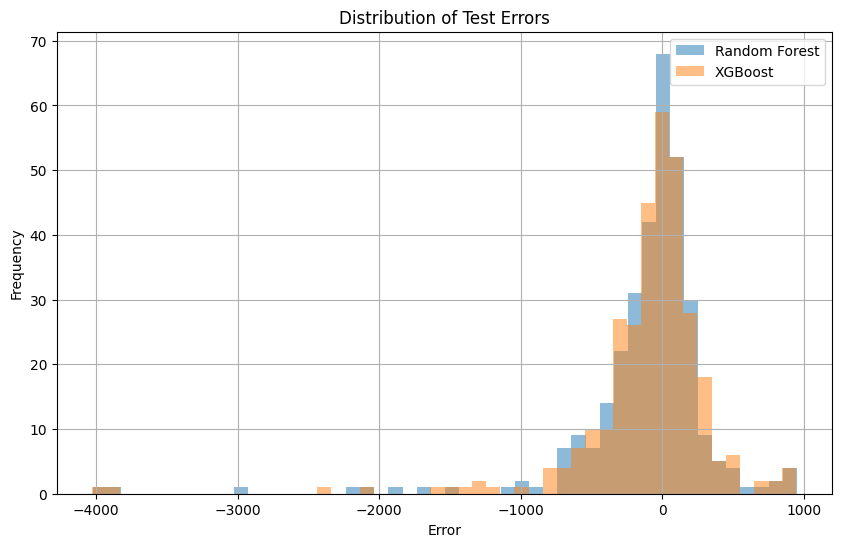

In [78]:
plt.figure(figsize=(10, 6))
plt.hist(
    np.array(rf_test_predictions) - np.array(rf_test_ground_truth),
    bins=50,
    alpha=0.5,
    label="Random Forest",
)
plt.hist(
    np.array(xgboost_test_predictions) - np.array(xgboost_test_ground_truth),
    bins=50,
    alpha=0.5,
    label="XGBoost",
)
plt.title("Distribution of Test Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid()